## Hypothesis testing: Testing the hypothesis of statistical significance

In this tutorial we will write the functions that tests the statistical significance. We will explain what is statistical significance which is used in sience for checking the scientific assumptions. 

Imagine that we want to examine whether a coin is fair, that is, whether the probability of a head falling is p = 0.5. Our test will specifically examine the fairness of tossing a coin n-times and counting how many times the head of X falls. Each toss of a coin is a Bernoulli test, meaning that X is a Binomial (n, p) random variable, which we can approximate using a normal distribution.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
from math import exp, expm1, sqrt, pi

In [2]:
def normal_approximation_to_binomial(n, p):
    """finds mean and standard deviation of the Binomial variable (n, p)"""
    mu = p * n
    sigma = math.sqrt(p * (1 - p) * n)
    return mu, sigma

Whenever a random variable follows a normal distribution, we can use normal_cdf to determine the probability that its realized value lies within (or outside) a given interval:

In [3]:
def normal_cdf(x, mu=0,sigma=1):
    return (1 + math.erf((x - mu) / math.sqrt(2) / sigma)) / 2

Let's say we have a variable with score on IQ test with mean 100 and standard deviation of 15 which is real values.

In [4]:
mean, stdev = 100, 15 # mean and standard deviation for IQ parameterds
normal_niz = np.random.normal(mean, stdev, 1000)

In [5]:
normal_niz.std() #we have some small noise due to the sampling procedure

14.473103658466457

In [6]:
normal_niz[3]

86.06666269312686

This function returns the percentile, ie for the entered value, returns the percentage of the area of the curve behind it, ie if it is the IQ percentage of the respondents behind it/
This means that person who has the score of 90 is smarter than 25% of individuals.

In [7]:
print(normal_cdf(90, mu=100, sigma=15)) 

0.25249253754692297


Person with an IQ score of 110 is smarter than 75% of population

In [8]:
print(normal_cdf(110, mu=100, sigma=15)) 

0.7475074624530771


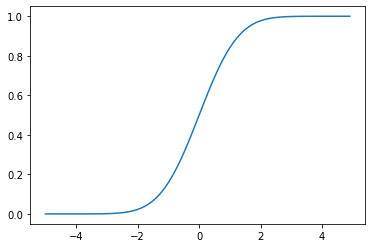

In [9]:
xs = [x / 10.0 for x in range(-50, 50)]
plt.plot(xs,[normal_cdf(x,sigma=1) for x in xs],'-',label='mu=0,sigma=1')
plt.show()
#this is what the cumulative normal distribution for x / 10 in the range of -50 to 50 looks like, with a standard deviation of 1

In [10]:
#the normal cdf represents the probability that the value of a variable is below a certain threshold (below 0, the probability is 0.5)
normal_probability_below = normal_cdf

# by subtracting this probability from one we get the probability that the value of the variable is above the threshold
def normal_probability_above(lo, mu=0, sigma=1):
    return 1 - normal_cdf(lo, mu, sigma)

# between is if it is less than hi a but not less lo
def normal_probability_between(lo, hi, mu=0, sigma=1):
    return normal_cdf(hi, mu, sigma) - normal_cdf(lo, mu, sigma)

# if it is not inside then it is outside that interval
def normal_probability_outside(lo, hi, mu=0, sigma=1):
    return 1 - normal_probability_between(lo, hi, mu, sigma)

What percentage of people are smarter than someone who has an IQ of 130?

In [11]:
print(round(100*normal_probability_above(130, mu=100, sigma=15),2), '%')

2.28 %


What percentage of people have an IQ between 110 and 130?

In [12]:
print(round(100*normal_probability_between(110, 130, mu=100, sigma=15),2), '%')

22.97 %


We can also do the opposite - find a surface or (symmetric) interval that represents a certain level of probability. For example, if we want to find an interval that is centered on the mean value and that contains 60% probability, we find intersections where the upper and lower tails contain 20% probability (up to the entire area representing 100%).

In [13]:
def inverse_normal_cdf(p, mu=0, sigma=1, tolerance=0.00001):
    """find approximate inverse using binary search"""
    # if not standard, compute standard and rescale
    if mu != 0 or sigma != 1:
        return mu + sigma * inverse_normal_cdf(p, tolerance=tolerance)
    low_z, low_p = -10.0, 0 # normal_cdf(-10) is (very close to) 0
    hi_z, hi_p = 10.0, 1 # normal_cdf(10) is (very close to) 1
    while hi_z - low_z > tolerance:
        mid_z = (low_z + hi_z) / 2 # consider the midpoint
        mid_p = normal_cdf(mid_z) # and the cdf's value there
        if mid_p < p:
            # midpoint is still too low, search above it
            low_z, low_p = mid_z, mid_p
        elif mid_p > p:
            # midpoint is still too high, search below it
            hi_z, hi_p = mid_z, mid_p
        else:
            break
    return mid_z

In [14]:
def normal_upper_bound(probability, mu=0, sigma=1):
    """returns the z for which P(Z <= z) = probability"""
    return inverse_normal_cdf(probability, mu, sigma)

def normal_lower_bound(probability, mu=0, sigma=1):
    """returns the z for which P(Z >= z) = probability"""
    return inverse_normal_cdf(1 - probability, mu, sigma)

def normal_two_sided_bounds(probability, mu=0, sigma=1):
    """returns the symmetric (about the mean) bounds that contain the specified probability"""
    tail_probability = (1 - probability) / 2
    # upper bound should have tail_probability above it
    upper_bound = normal_lower_bound(tail_probability, mu, sigma)
    # lower bound should have tail_probability below it
    lower_bound = normal_upper_bound(tail_probability, mu, sigma)
    return lower_bound, upper_bound

Which iq has a person whose iq occurs with a probability of 2%

In [15]:
normal_upper_bound(0.02, mu=100, sigma=15)

69.19379234313965

In [16]:
normal_lower_bound(0.02, mu=100, sigma=15)

130.80620765686035

In [17]:
normal_two_sided_bounds(0.02, mu=100, sigma=15)

(99.6239185333252, 100.3760814666748)

Specifically, let's say we decided to toss a coin n = 1000 times. If our equity hypothesis is true, X should be distributed approximately normally with a mean of 500 and a standard deviation of 15.8:

In [18]:
mu_0, sigma_0 = normal_approximation_to_binomial(1000, 0.5)
mu_0, sigma_0

(500.0, 15.811388300841896)

We have to make a decision about statistical significance - how much we are ready to make a type 1 error ("false positive", pregnant man), in which we reject H0 even though it is true. For historical reasons, this decision is often set at 5% or 1%. Let's choose 5%. Consider a test that rejects H0 if X falls outside the limits given through:

In [19]:
normal_two_sided_bounds(0.95, mu_0, sigma_0)

(469.01026640487555, 530.9897335951244)

This means that with a probability of 95% the arithmetic mean X is within the range 460-530 in a thousand coin tosses.
We are also often interested in the strength of the test, which is the probability that it will not make a type 2 mistake (tell a pregnant woman that she is not pregnant), in which we fail to reject X0 even though it is false. To measure this, we need to specify what exactly X0 means false. (If we only know that p is not 0.5 it does not give you a ton of information about the distribution of X.). Let's check what happens if p is really 0.55, so the coin is a little biased.
In this case, we can calculate the strength of the test using:

In [20]:
#95% bounds based on assumption p is 0.5
lo, hi = normal_two_sided_bounds(0.95, mu_0, sigma_0)
print(f'interval poverenja od 95% za simulaciju bacanja fer novcica, lower_bound:{round(lo,2)}, higher_bound:{round(hi,2)}')

# actual mu and sigma based on p = 0.55
mu_1, sigma_1 = normal_approximation_to_binomial(1000, 0.55)
print(f'kolike bi bile mean i stdev za pristasni novcic od 0.55, mean:{round(mu_1,2)}, stdev:{round(sigma_1,2)}')

# a type 2 error means we fail to reject the null hypothesis
# which will happen when X is still in our original interval
type_2_probability = normal_probability_between(lo, hi, mu_1, sigma_1)
print(f'koja je sansa da pogresimo sa intervalom poverenja od 95% za pristrasni novcic:{round(type_2_probability,2)}')
power = 1 - type_2_probability # 0.887
print(f'snaga testa:{round(power,2)}')

interval poverenja od 95% za simulaciju bacanja fer novcica, lower_bound:469.01, higher_bound:530.99
kolike bi bile mean i stdev za pristasni novcic od 0.55, mean:550.0, stdev:15.73
koja je sansa da pogresimo sa intervalom poverenja od 95% za pristrasni novcic:0.11
snaga testa:0.89


Imagine instead, our null hypothesis was that the coin is not biased toward the heads, or that p ≤ 0. 5. In this case we want a one-sided test that rejects the null hypothesis when X is much larger than 50, but not when X is smaller of 50. Thus, the 5% significance test involves the use of normal_probability_below to find the cross section below which lies the 95% probability:

In [21]:
hi = normal_upper_bound(0.95, mu_0, sigma_0)
# is 526 (< 531, since we need more probability in the upper tail)
type_2_probability = normal_probability_below(hi, mu_1, sigma_1)
power = 1 - type_2_probability # 0.936
print("hi", hi, "type_2_probability", type_2_probability, "power", power)

hi 526.0073585242053 type_2_probability 0.06362051966928273 power 0.9363794803307173


This is a more powerful test because it no longer rejects H0 when X is below 469 (which is unlikely to happen if H1 is true) and instead rejects H0 when X is between 526 and 531 (which can happen somewhat if H1 correct).
An alternative way of thinking about the previous test involves p-values. Instead of selecting the limits based on a certain probability cut-off, we calculate the probability - assuming that H0 is true - to see a value at least as extreme as the one we have and actually observe.
For our two-sided test of whether a coin is fair, we calculate:

In [22]:
def two_sided_p_value(x, mu=0, sigma=1):
    if x >= mu:
        # if x is greater than the mean, the tail is what's greater than x
        return 2 * normal_probability_above(x, mu, sigma)
    else:
    # if x is less than the mean, the tail is what's less than x
        return 2 * normal_probability_below(x, mu, sigma)
#If we were to see 530 heads, we would compute:
two_sided_p_value(529.5, mu_0, sigma_0) # 0.062

0.06207721579598835

One way to make sure this is a reasonable estimate is by simulation:

In [23]:
import random
extreme_value_count = 0
for _ in range(100000):
    num_heads = sum(1 if random.random() < 0.5 else 0 # count # of heads
                    for _ in range(1000)) # in 1000 flips
    if num_heads >= 530 or num_heads <= 470: # and count how often
        extreme_value_count += 1 # the # is 'extreme'
print (extreme_value_count / 100000) # 0.062

0.0619


In [24]:
two_sided_p_value(531.5, mu_0, sigma_0)

0.046345287837786575

In [25]:
upper_p_value = normal_probability_above
lower_p_value = normal_probability_below

In [26]:
upper_p_value(524.5, mu_0, sigma_0)

0.06062885772582072

In [27]:
upper_p_value(526.5, mu_0, sigma_0)

0.04686839508859242

That’s not entirely justified, but people seem to do it anyway. Using normal
distribution, we conclude that we are "95% sure" that the following interval contains the correct parameter p:

In [28]:
mu,sigma=500,15.8
normal_two_sided_bounds(0.95, mu, sigma)

(469.0325870513916, 530.9674129486084)

In [29]:
#With a coin falling 540 heads 
p_hat = 540 / 1000
mu = p_hat
sigma = math.sqrt(p_hat * (1 - p_hat) / 1000) # 0.0158
normal_two_sided_bounds(0.95, mu, sigma) # [0.5091, 0.5709]

(0.5091095927295919, 0.5708904072704082)